Visualizing and analyzing stocks

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from itertools import combinations, product
from functools import partial
from multiprocessing import Pool, Manager, cpu_count
from IPython.display import display_html
sns.set_context("notebook")

import warnings
warnings.filterwarnings("ignore")

This code is used to import necessary libraries and set up the environment for data analysis and visualization.   The code starts by importing the required libraries: numpy, pandas, glob, matplotlib.pyplot, seaborn, tqdm, itertools, functools, multiprocessing, and IPython.display.   The `%matplotlib inline` line is used to enable inline plotting in Jupyter Notebook, which allows for the automatic display of plots in the output cells.  Next, the code sets the appropriate visualization style using `sns.set_context("notebook")`, which is provided by the seaborn library. This will ensure that the visualizations produced later in the code have a consistent and aesthetically pleasing appearance in a notebook context.  Lastly, the code uses `warnings.filterwarnings("ignore")` to suppress any warning messages that may be generated during the execution of the code. This can be useful when dealing with large datasets or more complex operations.  Overall, this code sets up the necessary environment and configurations for data analysis and visualization, ensuring that the necessary libraries are imported, relevant settings are adjusted, and warning messages are ignored.

In [2]:
def prep_prices(price):
    
    from decimal import ROUND_HALF_UP, Decimal
    
    pcols = ["Open","High","Low","Close"]

    price.ExpectedDividend.fillna(0,inplace=True)
    
    def qround(x):
        return float(Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP))
    
    def adjust_prices(df):
        df = df.sort_values("Date", ascending=False)
        df.loc[:, "CumAdjust"] = df["AdjustmentFactor"].cumprod()

        # generate adjusted prices
        for p in pcols:     
            df.loc[:, p] = (df["CumAdjust"] * df[p]).apply(qround)
        df.loc[:, "Volume"] = df["Volume"] / df["CumAdjust"]
        df.ffill(inplace=True)
        df.bfill(inplace=True)
        
        # generate and fill Targets
        #df.loc[:, "Target"] = df.Close.pct_change().shift(-2).fillna(df.Target).fillna(0)
        df.Target.fillna(0,inplace=True)

        return df

    # generate Adjusted
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(adjust_prices).reset_index(drop=True)
    price = price.sort_values("RowId")
    return price

This code defines a function called prep_prices that takes in a parameter called price.   The function starts by importing the ROUND_HALF_UP and Decimal classes from the decimal module. It then creates a list called pcols containing the strings "Open", "High", "Low", and "Close".  The code then modifies the 'ExpectedDividend' column of the 'price' dataframe to replace any missing values with 0.  Two inner functions are defined within the prep_prices function. The first inner function, called qround, takes in a parameter x and returns a float rounded to the nearest 0.1 using the ROUND_HALF_UP rounding method.  The second inner function, called adjust_prices, takes in a dataframe called df. It first sorts the dataframe in descending order based on the "Date" column. It then adds a new column called "CumAdjust" to the dataframe, which is calculated by taking the cumulative product of the values in the "AdjustmentFactor" column.   The code then iterates over each element p in the pcols list and modifies the corresponding column p in the dataframe by multiplying it with the values in the "CumAdjust" column and applying the qround function to the result. The "Volume" column is also modified by dividing it with the values in the "CumAdjust" column. Any missing values in the dataframe are filled using forward fill (ffill) and backward fill (bfill) methods.  Next, the code generates and fills the "Targets" column of the dataframe by calculating the percent change of the "Close" column, shifting the result by 2 periods, and filling any missing values with 0.  The adjust_prices function then returns the modified dataframe.  The main part of the prep_prices function sorts the "price" dataframe first by the "SecuritiesCode" column and then by
the "Date" column. It then groups the dataframe by the "SecuritiesCode" column and applies the adjust_prices function to each group. The resulting dataframe is reset to have a default index and sorted by the "RowId" column.  Finally, the prep_prices function returns the modified "price" dataframe.

In [3]:
%%time
path = "../input/jpx-tokyo-stock-exchange-prediction/"

df_train = pd.read_csv(f"{path}train_files/stock_prices.csv", parse_dates=["Date"])
df_train = df_train[df_train.Date>"2020-10-02"] #Targets not Nulls and 2000 secutities data
df_train = prep_prices(df_train)

df_test = pd.read_csv(f"{path}supplemental_files/stock_prices.csv", parse_dates=["Date"])
df_test = prep_prices(df_test)

CPU times: user 43.7 s, sys: 873 ms, total: 44.6 s
Wall time: 46.5 s


This code is mainly focused on reading and preparing stock price data for training and testing purposes.   The code starts with the line "%%time", which is a Jupyter Notebook magic command that measures the execution time of the code.  Next, the code defines the path variable as the relative path to the directory where the stock price data is stored.  The code then reads the training data file "stock_prices.csv" from the specified path using the pandas library's `read_csv` function. It also specifies that the "Date" column in the data should be parsed as dates.  After reading the training data, the code filters the data by selecting only the rows where the "Date" is greater than "2020-10-02". This filters out any data before that date.  The code then calls the `prep_prices` function which is not shown in the given code snippet. This function seems to perform some data preparation or preprocessing on the training data.  Next, the code reads the testing data file "stock_prices.csv" from the same path using the `read_csv` function. It also parses the "Date" column as dates.  Similar to the training data, the code calls the `prep_prices` function to prepare or preprocess the testing data.  Overall, this code snippet reads stock price data from two different files (training and testing), filters the data based on the "Date" column, and applies some kind of data preparation using the `prep_prices` function.

In [4]:
# create new dataframe with just closing price for each stock
df = df_train.pivot(index='Date', columns='SecuritiesCode', values='Close')

This code is used to create a new dataframe that contains only the closing prices for each stock. The original dataframe is named "df_train", and it has columns such as "Date", "SecuritiesCode", and "Close". The code uses the pivot method to reshape the dataframe, where the index becomes the "Date" column, the columns become the unique values from the "SecuritiesCode" column, and the values are taken from the "Close" column.  By applying this pivot operation, the resulting dataframe will have the date as the row index, with each unique securities code as a column, and the corresponding closing prices as the values. This allows for easy analysis and comparison of the closing prices of different stocks over time.  Overall, this code is useful for organizing the closing price data for each stock in a concise and easy-to-analyze format.

In [5]:
def absHighPass(df, absThresh):
    df.loc[:, ]
    passed = set()
    for (r,c) in combinations(df.columns, 2):
        if (abs(df.loc[r,c]) >= absThresh):
            passed.add(r)
            passed.add(c)
    passed = sorted(passed)
    return df.loc[passed,passed]

corr = df.corr()

This code defines a function called "absHighPass" that takes two arguments - a DataFrame (df) and a threshold value (absThresh). This function filters the DataFrame based on the absolute value of the correlation coefficient between pairs of columns.  Inside the function, an empty set called "passed" is created to store the column names that pass the threshold condition. The code then iterates over all possible combinations of column pairs using the "combinations" function from the itertools module. For each pair, it checks if the absolute value of the correlation coefficient between them is greater than or equal to the threshold value. If it is, the column names are added to the "passed" set.  After iterating through all column pairs, the "passed" set is sorted to ensure consistent order across different executions. Finally, the function returns a new DataFrame that includes only the columns that passed the threshold, and only the rows and columns corresponding to those columns.  The last line outside the function calculates the correlation matrix of the original DataFrame (df) and assigns it to a variable named "corr". This is likely done as a preprocessing step before applying the "absHighPass" function.

Search High Correlations Stocks

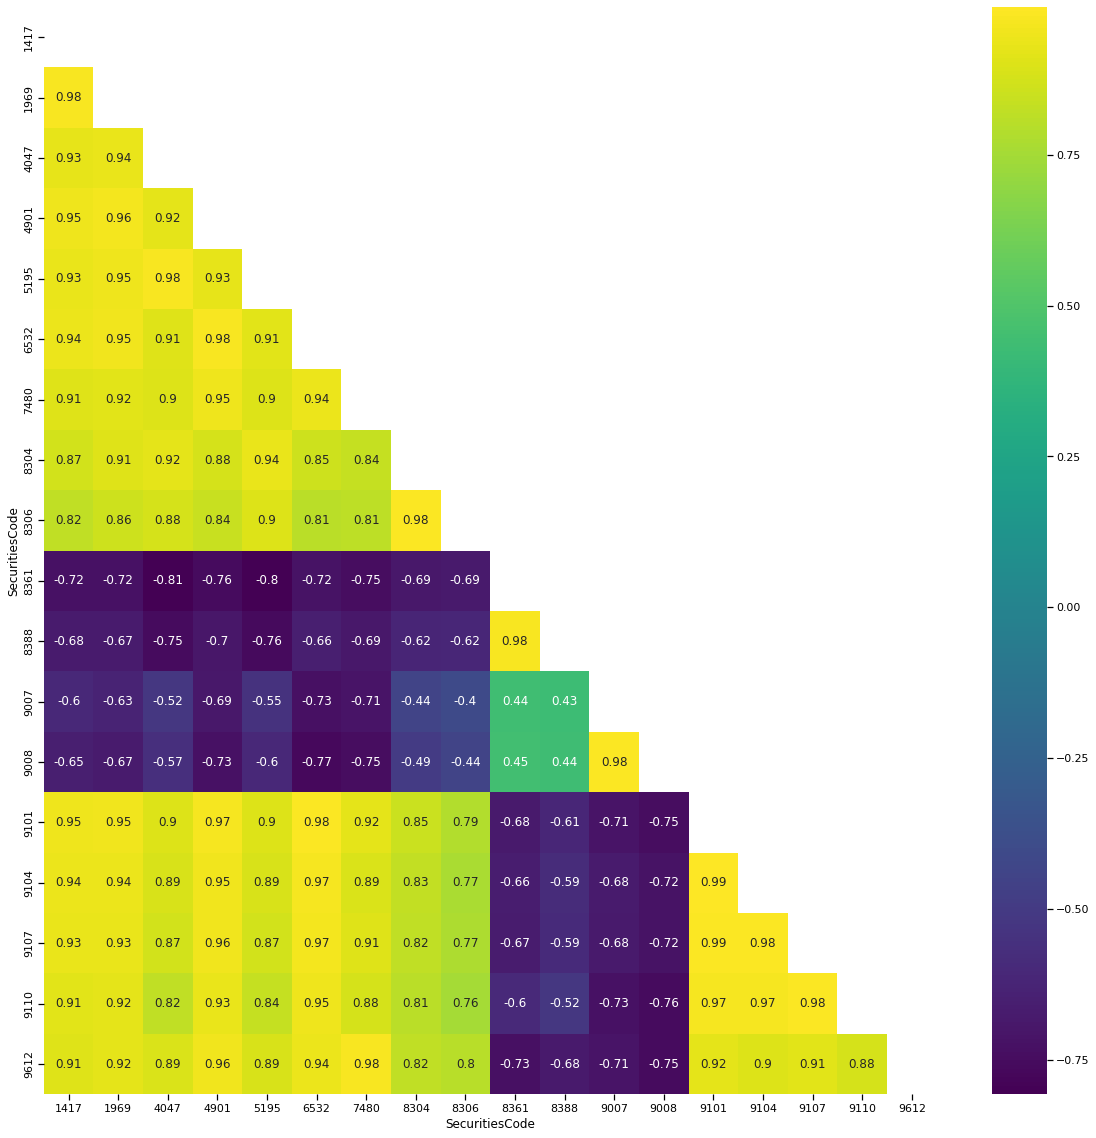

In [6]:
mat = absHighPass(corr,0.978)
mask = np.triu(np.ones_like(mat))
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(mat, annot=True, mask=mask, cmap="viridis")
plt.show()

This code performs a high-pass filter on a given matrix (corr) and stores the resulting matrix in the variable "mat". The high-pass filter removes low-frequency noise from the matrix and highlights the high-frequency components.  The next line of code creates a mask, which is an upper triangular matrix filled with ones, having the same shape as the "mat" matrix. This mask is used to hide the lower triangular part of the heatmap that will be generated later.  Then, the code creates a figure and axes using the matplotlib library. The figsize argument determines the size of the resulting figure, which is set to 20x20 in this case.  Finally, the code generates a heatmap using the seaborn library. The "mat" matrix is used as the data for the heatmap. The annot argument is set to True, which means that the heatmap will display the actual values of the matrix on top of each cell. The mask is applied to hide the lower triangular part of the heatmap. The cmap argument determines the color map used to display the values.  After creating the heatmap, the code displays it using the plt.show() function.

Pair with high correlation

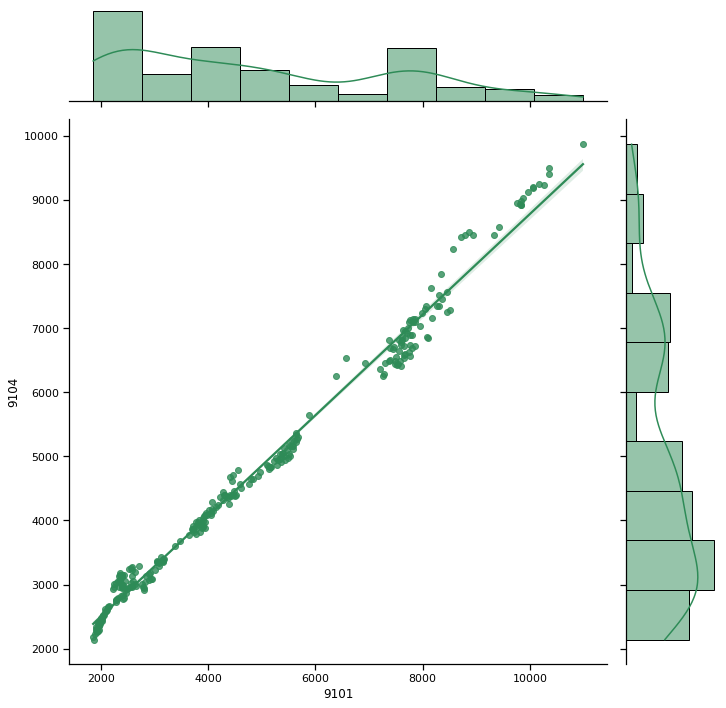

In [7]:
sns.jointplot(9101, 9104, df, kind='reg', color='seagreen', height=10);

This code utilizes the jointplot function from the seaborn library to plot a joint distribution and a regression line for two variables in a given dataset. The variables being plotted are 9101 and 9104. The dataset used for plotting is specified as 'df'. The kind parameter is set to 'reg', indicating that the joint distribution plot will include a regression line to visualize the relationship between the two variables.  Additionally, the color parameter is set to 'seagreen', which determines the color palette used for the plot. The height parameter is set to 10, which determines the height of the plot.  Overall, this code generates a joint distribution plot with a regression line for the variables 9101 and 9104, using the specified dataset 'df' and customizing the color and height of the plot.

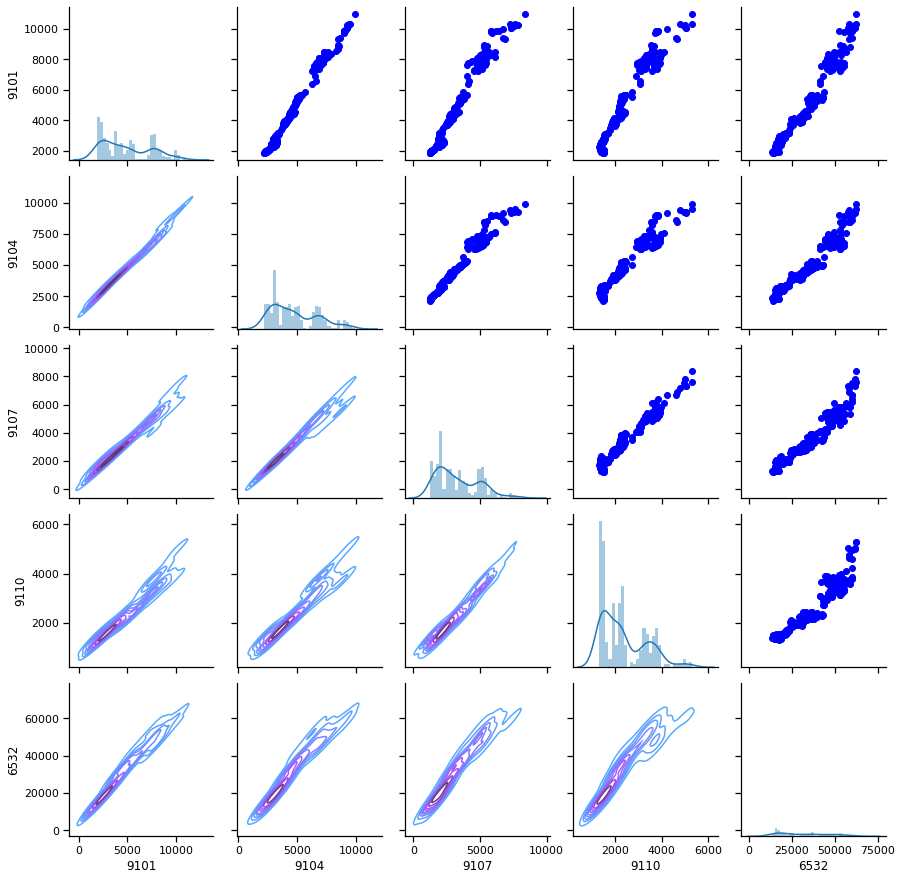

In [8]:
fig = sns.PairGrid(df[[9101, 9104, 9107, 9110, 6532]].dropna())
fig.map_upper(plt.scatter, color='blue')
fig.map_lower(sns.kdeplot, cmap='cool_d')
fig.map_diag(sns.distplot, bins=30);

This code is using the seaborn library to create a PairGrid plot with specific columns from a dataframe.   The first line selects the columns with the indices 9101, 9104, 9107, 9110, and 6532 from the dataframe 'df' and drops any rows that have missing values. These columns are then used to create the PairGrid object 'fig'.  The second line uses the 'map_upper' method of the 'fig' object to map a scatter plot using the 'plt.scatter' function. The 'color' parameter is set to 'blue', indicating that the scatter points should be colored in blue. This plots the scatter plot in the upper triangle of the PairGrid.  The third line uses the 'map_lower' method of the 'fig' object to map a kernel density estimate (KDE) plot using the 'sns.kdeplot' function. The 'cmap' parameter is set to 'cool_d', indicating the color map to be used for the plot. This plots the KDE plot in the lower triangle of the PairGrid.  The fourth line uses the 'map_diag' method of the 'fig' object to map a distribution plot using the 'sns.distplot' function. The 'bins' parameter is set to 30, indicating the number of bins in the histogram. This plots the distribution plot along the diagonal of the PairGrid.  Overall, this code generates a grid of plots where each cell contains a scatter plot, a KDE plot, or a distribution plot depending on the position within the grid. This is a useful visualization technique for exploring the relationships between multiple variables in a dataset.

Stock Charts 

In [9]:
Code = 9101 # Select Security Code

The given code appears to be a variable assignment statement, where the value '9101' is being assigned to a variable named 'Code'. This line of code serves as a way to store the security code, possibly used for authentication purposes, in a program or system.  The purpose of this line of code is to select a specific security code, represented by the value '9101', and assign it to the variable named 'Code'. By doing so, the code establishes a reference to this security code, allowing it to be used later in the program for verifying user identity or granting access to certain features or resources.  This line of code is written in a programming language and it serves a specific purpose within the context of a larger program or system. Without further information about the specific use or implementation of this code within its broader context, it is not possible to provide a more detailed explanation of its functionality or significance.

In [10]:
cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'SecuritiesCode', 'Target']
STOCK = df_train[df_train.SecuritiesCode==Code][cols].set_index("Date")
TEST = df_test[df_test.SecuritiesCode==Code].set_index("Date")
display_html(STOCK)

,Open,High,Low,Close,Volume,SecuritiesCode,Target
Date,,,,,,,
2020-10-05,1863.0,1898.0,1856.0,1872.0,1439600.0,9101,0.013470
2020-10-06,1892.0,1894.0,1846.0,1856.0,1634300.0,9101,0.023392
2020-10-07,1850.0,1889.0,1841.0,1881.0,1548400.0,9101,0.019740
2020-10-08,1921.0,1950.0,1918.0,1925.0,2226000.0,9101,-0.011717
2020-10-09,1934.0,1968.0,1931.0,1963.0,1868400.0,9101,-0.002577
...,...,...,...,...,...,...,...
2021-11-29,7270.0,7710.0,7270.0,7550.0,6589500.0,9101,0.025676
2021-11-30,7650.0,7670.0,7400.0,7400.0,5593800.0,9101,0.052701
2021-12-01,7540.0,7670.0,7390.0,7590.0,5099900.0,9101,0.021277


This code snippet performs several operations on two dataframes, df_train and df_test.   Firstly, it creates a list called cols that contains the column names 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'SecuritiesCode', and 'Target'.   Then, it uses the variable Code to filter the df_train dataframe and select only the rows where the SecuritiesCode column is equal to the Code value. The selected rows are stored in a new dataframe called STOCK, which includes only the columns specified in the cols list. The Date column is then set as the index for the STOCK dataframe.  Next, a similar operation is performed on the df_test dataframe. It filters the rows where the SecuritiesCode column is equal to the Code value and stores the selected rows in a new dataframe called TEST. The Date column is set as the index for the TEST dataframe.  Finally, the display_html function is called with the STOCK dataframe as the argument. This function likely displays the contents of the STOCK dataframe in a visually readable format.

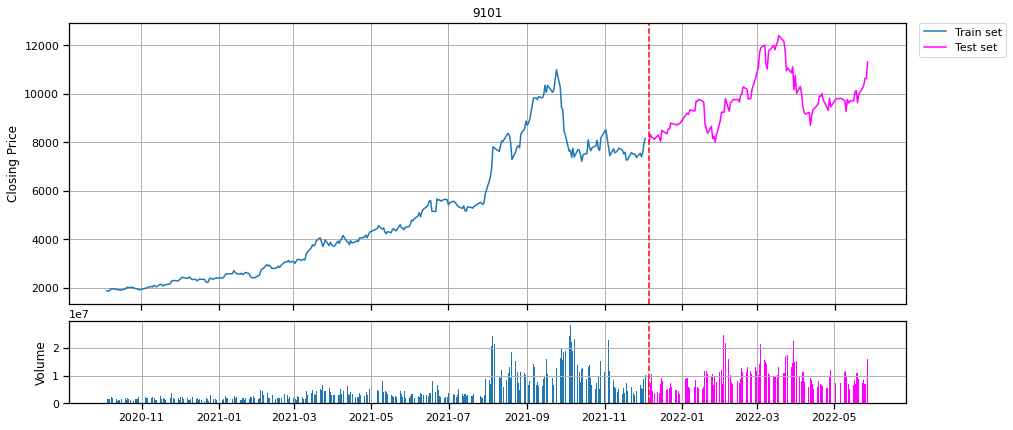

In [11]:
plt.figure(figsize=(15,7))
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
top.plot(STOCK.index, STOCK.Close, label="Train set")
top.plot(TEST.index,TEST.Close, color="magenta", label="Test set")
bottom.bar(STOCK.index, STOCK.Volume)
bottom.bar(TEST.index, TEST.Volume, color="magenta")
top.legend(bbox_to_anchor=(1.01, 1., 0.11, 0.), loc='upper right', borderaxespad=0.)
 
# set the labels
top.axes.xaxis.set_ticklabels([])
top.axvline(TEST.index[0], color='red', linestyle='--')
bottom.axvline(TEST.index[0], color='red', linestyle='--')
top.set_title(Code)
top.grid(True)
top.set_ylabel('Closing Price')
bottom.set_ylabel('Volume')
bottom.grid(True);

This code is using the matplotlib library in Python to create a figure with two subplots. The top subplot is larger and contains two plots, one for the "Train set" and one for the "Test set" of stock prices. The bottom subplot is smaller and contains two bar plots, one for the volume of the "Train set" and one for the volume of the "Test set".  In the top subplot, the code uses the `plot` function to plot the closing prices of the stock for both the "Train set" and "Test set" on the same plot. The `label` parameter is used to provide a legend for the two lines.   In the bottom subplot, the code uses the `bar` function to plot the volume of the stock for both the "Train set" and "Test set" on the same plot. The `color` parameter is used to change the color of the bars for the "Test set".  The `legend` function is used to create a legend for the top subplot. The `bbox_to_anchor` and `loc` parameters are used to position the legend outside of the plot.   The code then sets the tick labels on the x-axis of the top plot to an empty list, effectively removing them. It also adds a vertical line at the start of the "Test set" using the `axvline` function with the `color` and `linestyle` parameters. This is done in both the top and bottom subplots.  The `set_title` function is used to set the title of the top plot to a variable called `Code`. The `grid` function is used to add grid lines to both the top and bottom plots.   Finally, the code sets the y-axis labels for both plots to "Closing Price" and "Volume" respectively using the `set_ylabel` function.

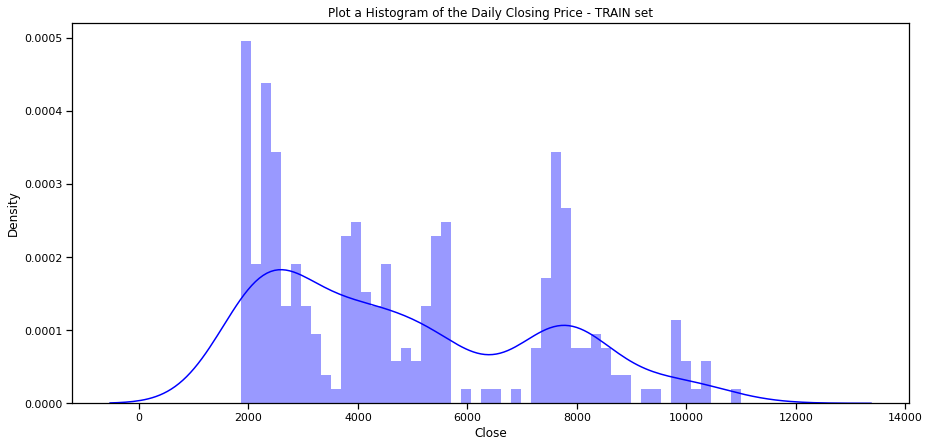

In [12]:
plt.figure(figsize=(15,7))
plt.title("Plot a Histogram of the Daily Closing Price - TRAIN set")
sns.distplot(STOCK['Close'].dropna(), bins=50, color='blue');

This code uses the matplotlib and seaborn libraries to plot a histogram of the daily closing prices of a stock.   The first line `plt.figure(figsize=(15,7))` creates a new figure with a specified size of 15 inches in width and 7 inches in height. This ensures that the histogram will be displayed in a larger, more visible format.  The second line `plt.title("Plot a Histogram of the Daily Closing Price - TRAIN set")` sets the title of the plot as "Plot a Histogram of the Daily Closing Price - TRAIN set". This provides a clear description of what the plot represents.  The third line `sns.distplot(STOCK['Close'].dropna(), bins=50, color='blue')` actually creates the histogram. Here, `STOCK['Close']` refers to the column of data containing the daily closing prices of the stock. The `.dropna()` function removes any missing or NaN (Not a Number) values from the data.   The `bins=50` parameter specifies that the histogram should be divided into 50 equal bins. This determines the number of bars or columns in the histogram.  The `color='blue'` parameter sets the color of the bars in the histogram to blue. This can be customized to any other color if desired.  Overall, this code generates a histogram that provides a visual representation of the distribution of daily closing prices for a stock. The larger figure size and clear title make the plot easy to interpret.

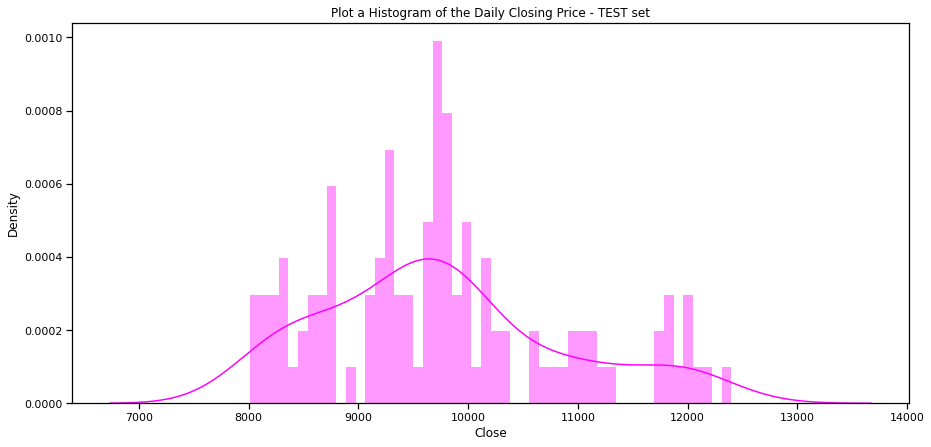

In [13]:
plt.figure(figsize=(15,7))
plt.title("Plot a Histogram of the Daily Closing Price - TEST set")
sns.distplot(TEST['Close'].dropna(), bins=50, color='magenta');

This code is used to plot a histogram of the daily closing price for a test set of data.   The first line of code sets the size of the figure or plot to be generated with a width of 15 units and a height of 7 units. This ensures that the plot is displayed in a suitable size.  The second line of code sets the title of the plot to "Plot a Histogram of the Daily Closing Price - TEST set". This provides a descriptive title for the plot, indicating the purpose and dataset being visualized.  The third line of code uses the seaborn library (imported as sns) to create the histogram plot. The data for the histogram is the 'Close' column from the TEST dataset, which is selected using the syntax 'TEST['Close']'. The 'dropna()' function is used to remove any missing or null values from the 'Close' column before plotting. The 'bins' parameter is set to 50, indicating that the histogram should be divided into 50 equal bins or bars. Finally, the 'color' parameter is set to 'magenta', specifying the color of the bars in the histogram plot.   Overall, this code displays a histogram plot of the daily closing price for a test dataset, providing a visual representation of the distribution of closing prices. The plot is customized with a specific figure size and title, and the seaborn library is used to generate the histogram.

Forecasting stock prices

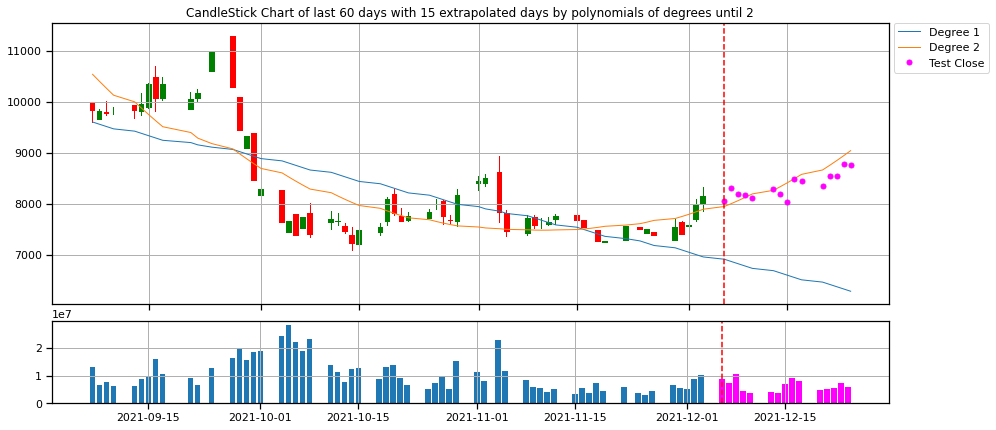

In [14]:
d = 60 # days to plot
e = 15  # days to extrapolate
g = 2  # max degree of regression

width = .8
width2 = .1
col1 = 'green'
col2 = 'red'

LDAYS = STOCK.tail(d)
up = LDAYS[LDAYS.Close>=LDAYS.Open]
down = LDAYS[LDAYS.Close<LDAYS.Open]
fut = TEST[TEST.index<=TEST.head(e).index[-1]]

xd = (LDAYS.index).append(TEST.head(e).index)

x = [x for x in range(d)]
p = {}
for i in range(g):
    z = np.polyfit(x, LDAYS.Close, i+1)
    p[i] = np.poly1d(z)
x = np.array(range(d+e))

plt.figure(figsize=(15,7))
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
top.set_title(f"CandleStick Chart of last {d} days with {e} extrapolated days by polynomials of degrees until {g}")
top.axes.xaxis.set_ticklabels([])
for i in range(g):
    top.plot(xd, p[i](x), linewidth=1, label=f'Degree {i+1}')
top.plot(fut.index,fut.Close,  marker="o", markersize=5, color="magenta", linewidth=0, label="Test Close")
top.bar(up.index,up.Close-up.Open,width,bottom=up.Open,color=col1)
top.bar(up.index,up.High-up.Close,width2,bottom=up.Close,color=col1)
top.bar(up.index,up.Low-up.Open,width2,bottom=up.Open,color=col1)
top.bar(down.index,down.Close-down.Open,width,bottom=down.Open,color=col2)
top.bar(down.index,down.High-down.Open,width2,bottom=down.Open,color=col2)
top.bar(down.index,down.Low-down.Close,width2,bottom=down.Close,color=col2)
top.axvline(TEST.index[0], color='red', linestyle='--')
top.legend(bbox_to_anchor=(1.01, 1., 0.11, 0.), loc='upper right', borderaxespad=0.)
top.grid(True)

bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
bottom.bar(xd, np.append(LDAYS['Volume'].values,np.zeros(e))) 
bottom.bar(fut.index, fut.Volume, color="magenta") 
bottom.axvline(TEST.index[0], color='red', linestyle='--')

bottom.grid(True)
plt.show();

This code is used to plot a candlestick chart of stock data for a specified number of days, with an additional extrapolation for a specified number of future days.   The code first sets the values for the number of days to plot (d), the number of days to extrapolate (e), and the maximum degree of regression (g).   Next, it selects the most recent d days of stock data and separates them into two groups: those with a closing price greater than or equal to the opening price (up) and those with a closing price lower than the opening price (down). It also selects the first e days of future stock data.  The code then creates a combined index of x-axis values by appending the indexes of the selected d and e days.  Using the selected d days of stock data, the code proceeds to calculate polynomial regression curves of different degrees (up to the maximum g) to fit the closing prices. These curves are stored in a dictionary.  The code creates a figure to display the candlestick chart and sets the title based on the selected values of d, e, and g. It also removes the tick labels from the x-axis of the chart.  For each degree of regression, the code plots the polynomial curve using the calculated regression coefficients. It also plots the closing prices for the future days, represented by markers on the chart. Additionally, it plots bars to represent the differences between opening and closing prices, as well as the differences between highs and opens and lows and opens, for both the up and down groups.  A vertical line is drawn at the first index of the future stock data to indicate the separation between the known and extrapolated data.  The legend is positioned at the upper-right corner of the chart, and the gridlines are enabled.  The code then creates a subplot at the bottom of the figure to
display the volume information for each day. It plots bars for the volume of the selected d days, with zero values appended to account for the future days. It also plots the volume of the future days using a different color. A vertical line is drawn at the first index of the future stock data.  The gridlines are enabled for the subplot.  Finally, the chart is displayed.

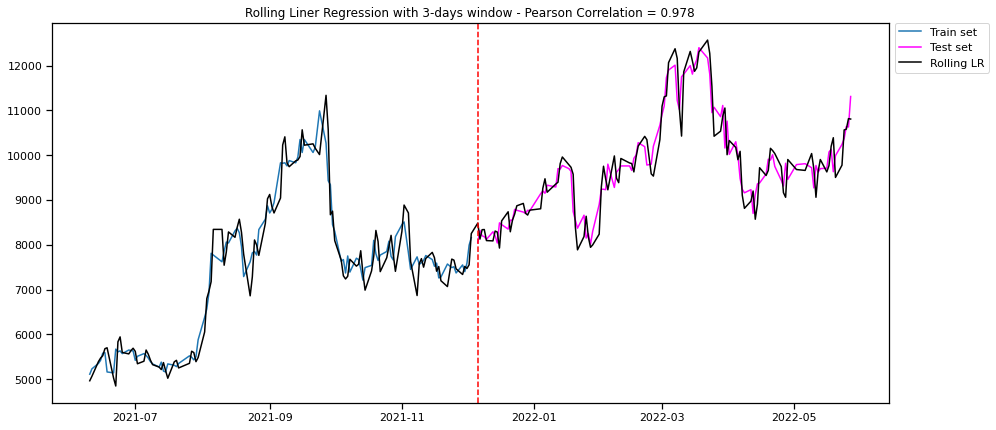

In [15]:
d = 120 # days to plot
w = 3 # windows size

LDAYS = STOCK.tail(d)
fut = pd.concat([STOCK,TEST])
xd = (LDAYS.index).append(TEST.index)

fut['Cl_lr'] = fut.Close.rolling(window=w,closed="left").apply(lambda y: 
                   np.poly1d(np.polyfit(np.array(range(w)),y,1))(w),raw=True)

fut['Cl2'] = fut.Close.rolling(window=2,closed="left").apply(lambda y: 
                   np.poly1d(np.polyfit([0,1],y,1))(2),raw=True)

rho = np.corrcoef(fut.Close[-len(xd):],fut.Cl_lr[-len(xd):])

plt.figure(figsize=(15,7))
plt.plot(LDAYS.index, LDAYS.Close, label="Train set")
plt.plot(TEST.index,TEST.Close, color="magenta", label="Test set")
plt.plot(xd,fut.Cl_lr[-len(xd):], color="black", label="Rolling LR")
plt.axvline(TEST.index[0], color='red', linestyle='--')
plt.title(f"Rolling Liner Regression with {w}-days window - Pearson Correlation = {rho[0,1]:.3f}")
plt.legend(bbox_to_anchor=(1.01, 1., 0.11, 0.), loc='upper right', borderaxespad=0.)
plt.show();

This code is performing a rolling linear regression analysis on a stock's closing price data.   First, it sets the variables 'd' and 'w' to determine the number of days to plot and the window size for the regression analysis, respectively.   Next, it selects the last 'd' days of stock data and assigns it to the variable 'LDAYS'.   Then, it concatenates the stock data with a test data set and saves it as 'fut'.   To calculate the rolling linear regression, the code defines a lambda function that takes a window of closing price data and applies a polynomial fit of degree 1 (representing a linear fit) to it. The window size used for the regression is 'w'. The result is saved in the 'Cl_lr' column of the 'fut' dataframe.   Similarly, a rolling linear regression with a window size of 2 is applied to the closing price data and saved in the 'Cl2' column of the 'fut' dataframe.   The code then calculates the Pearson correlation coefficient ('rho') between the last 'd' days of closing price data and the 'Cl_lr' column of the 'fut' dataframe.   Finally, the code plots the training set, test set, the rolling linear regression line, and a vertical line to indicate the start of the test set. The title of the plot includes the window size used for the regression and the Pearson correlation coefficient.

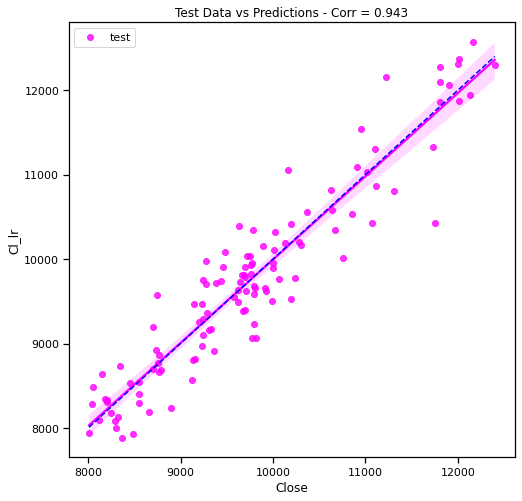

In [16]:
# Generate diagonal line to plot.
fig, ax = plt.subplots(figsize=(8,8))
d_x = np.linspace(start=TEST.Close.min() - 1, stop=TEST.Close.max() + 1, num=100)
sns.regplot(x=TEST.Close, y=fut.Cl_lr[-len(TEST):], color='magenta', label='test', ax=ax)
sns.lineplot(x=d_x, y=d_x, dashes={'linestyle': ''}, color='blue', ax=ax)
ax.lines[1].set_linestyle('--')
ax.set(title=f'Test Data vs Predictions - Corr = {np.corrcoef(TEST.Close,fut.Cl_lr[-len(TEST):])[0,1]:.3f}');

This code generates a scatter plot with a diagonal line.   First, it creates a figure and axes object with a specified size of 8 by 8 inches.   Next, it generates a range of x-values called "d_x" that spans from the minimum value of the "TEST.Close" variable minus 1, to the maximum value of "TEST.Close" plus 1. This range will be used to plot the diagonal line.   Then, it uses the Seaborn library's "regplot" function to create a scatter plot. The x-axis values are taken from "TEST.Close" and the y-axis values are taken from the "fut.Cl_lr" variable, specifically the values corresponding to the last len(TEST) number of elements. The points in the scatter plot are colored magenta and labeled as "test".   After that, it uses the Seaborn library's "lineplot" function to create a line plot with the diagonal line. The x-axis values are taken from the "d_x" range and the y-axis values are also taken from the "d_x" range. The line is colored blue and has no dash linestyle.   Then, it sets the linestyle of the second line in the axes object to be dashed.   Finally, it sets the title of the plot to include the correlation coefficient between "TEST.Close" and the selected "fut.Cl_lr" values, rounded to three decimal places.

Prophet Forecasting

In [17]:
from fbprophet import Prophet
from fbprophet.make_holidays import make_holidays_df

year_list = [2017, 2018, 2019, 2020, 2021, 2022, 2023]
holidays = make_holidays_df(year_list=year_list, country='JP')

ph_df = fut[["Close","Cl_lr",'Cl2']][w:len(STOCK)].reset_index()
ph_df.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

m = Prophet(holidays=holidays,
            daily_seasonality=False,
            changepoint_prior_scale=0.015)
m.add_seasonality(name='monthly', period=20.5, fourier_order=5)
m.add_regressor('Cl_lr')
m.add_regressor('Cl2')
m.fit(ph_df)

Initial log joint probability = -3.25197


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       934.939    0.00104691       566.453      0.8832      0.8832      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       946.066   0.000476999       479.101   4.314e-07       0.001      214  LS failed, Hessian reset 
     199       949.626     0.0032802       331.025           1           1      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       951.139   0.000360137       464.591   9.143e-07       0.001      348  LS failed, Hessian reset 
     299       952.841   8.17119e-06       303.584      0.6151      0.6151      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     395       952.963   9.46974e-09       268.961     0.04008           1      580   
Optimization terminated normally: 
  Convergence detected: abs

This code is using the Prophet library from Facebook's Prophet package to perform time series forecasting. The code starts by importing the Prophet module and the make_holidays_df function from the make_holidays module.  Next, a list of years is defined, from 2017 to 2023, and the make_holidays_df function is called to create a DataFrame of holidays for those years in Japan. This holidays DataFrame will be used as input to Prophet.  Then, a DataFrame called ph_df is created by selecting the "Close", "Cl_lr", and "Cl2" columns from the fut DataFrame (assuming this DataFrame exists) and resetting the index. The columns are also renamed to 'y' and 'ds' to match the Prophet's required column names for the target variable (y) and the date/time (ds).  The code then creates a Prophet model instance (m) and passes the holidays DataFrame as well as some other parameters such as daily_seasonality and changepoint_prior_scale. The daily_seasonality is set to False to disable daily seasonality, and the changepoint_prior_scale is set to 0.015 to control the flexibility of the trend.  Additionally, two regressors, 'Cl_lr' and 'Cl2', are added to the model using the add_regressor method. These regressors are additional variables that can be used to enhance the forecasting model.  Finally, the model is fit to the ph_df DataFrame using the fit method, which performs the actual model training and forecasting.

Compare Predict and Future Close

In [18]:
TEST.shape

(115, 12)

The code `TEST.shape` is used to find and display the shape of a dataset or a data structure, specifically a Pandas DataFrame or a NumPy array. The shape of a dataset refers to the dimensions or structure of the data, including the number of rows and columns.  When this code is executed, it will return a tuple that contains two values. The first value represents the number of rows in the dataset, while the second value represents the number of columns. For example, if the shape of the dataset is (100, 5), it means that there are 100 rows and 5 columns in the dataset.  This information is especially useful when working with large datasets, as it provides an understanding of the size and structure of the data. It can help with tasks such as data cleaning, data manipulation, and data analysis. By knowing the shape of the dataset, one can make decisions on how to approach and process the data effectively.  Additionally, knowing the shape of a dataset can provide insights into the type and nature of the data. For example, if the dataset has a large number of columns compared to the number of rows, it could indicate that the dataset contains a wide range of variables or features. On the other hand, if there are many rows but only a few columns, it could suggest a large amount of observational data.  Overall, the code `TEST.shape` is a simple and convenient way to retrieve and display the shape or dimensions of a dataset, giving valuable information about its size, structure, and potential insights into the data.

In [19]:
# Predict Prices
future_prices = m.make_future_dataframe(periods=175, freq='d')
future_prices = future_prices[future_prices.ds.dt.dayofweek < 5]
future_prices = future_prices.set_index("ds").join(fut[['Cl_lr','Cl2']][w:], how='left')
future_prices = future_prices.reset_index().dropna()
forecast = m.predict(future_prices)
result = TEST[['Close']].join(forecast[['ds','yhat','yhat_lower','yhat_upper']].set_index("ds"),how='left')
display_html(result)

,Close,yhat,yhat_lower,yhat_upper
Date,,,,
2021-12-06,8050.0,8563.194948,8289.136403,8867.380110
2021-12-07,8320.0,8164.064841,7888.116805,8475.771725
2021-12-08,8200.0,8418.106219,8123.658843,8725.938382
2021-12-09,8180.0,8285.244694,7987.939481,8595.128795
2021-12-10,8120.0,8187.796954,7884.838792,8476.642655
...,...,...,...,...
2022-05-23,10240.0,10091.556739,9793.167549,10401.707167
2022-05-24,10370.0,10663.948861,10360.311567,10963.950147
2022-05-25,10640.0,10711.300405,10419.246648,10991.077965


This code predicts prices using a time series forecasting model.   First, it creates a future dataframe that includes a range of future dates based on the current date, with a specified frequency of daily periods.   Then, it filters out any dates that are not weekdays (Monday to Friday) by checking the day of the week using the "dt.dayofweek" function of the "ds" (datestamp) column in the future_prices dataframe.   Next, it sets the index of the future_prices dataframe to the "ds" column and joins it with certain columns ('Cl_lr' and 'Cl2') from another dataframe called "fut", starting from a specific index "w". The join is performed using a left join, which means only the rows with matching values in the "ds" column are included in the result.  After that, it resets the index of the future_prices dataframe and drops any rows with missing values (NaN) from the dataframe.  Then, it uses the "predict" method of a time series forecasting model called "m" to generate forecasts for the future_prices dataframe.  The code then combines the "Close" column from a dataframe called "TEST" with certain columns
('ds', 'yhat', 'yhat_lower', 'yhat_upper') from the forecast dataframe, using the "join" method. The join is performed using a left join, which means only the rows with matching values in the "ds" column are included in the result. The result is stored in a dataframe called "result".  Finally, it displays the "result" dataframe using the "display_html" function.  Overall, this code takes a time series forecasting model, generates future dates, filters out non-weekdays, performs a join operation with another dataframe, generates predictions for the future dates, combines the predictions with the original data, and displays the results.

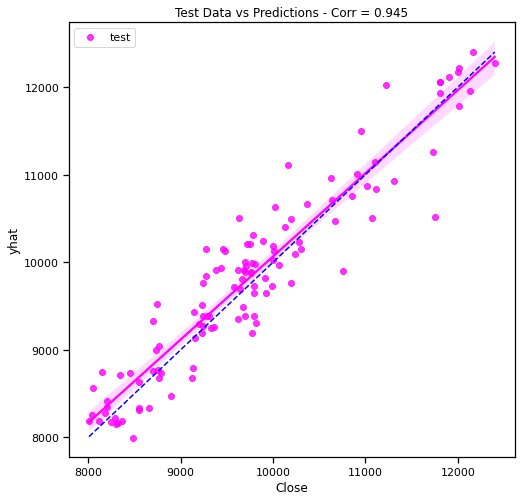

In [20]:
# Generate diagonal line to plot.
rho = np.corrcoef(result.Close,result.yhat)
fig, ax = plt.subplots(figsize=(8,8))
d_x = np.linspace(start=TEST.Close.min() - 1, stop=TEST.Close.max() + 1, num=175)
sns.regplot(x=result.Close, y=result.yhat, color='magenta', label='test', ax=ax)
sns.lineplot(x=d_x, y=d_x, dashes={'linestyle': ''}, color='blue', ax=ax)
ax.lines[1].set_linestyle('--')
ax.legend(loc='upper left')
ax.set(title=f'Test Data vs Predictions - Corr = {np.corrcoef(result.Close,result.yhat)[0,1]:.3f}');

This code generates a diagonal line plot to compare test data with predictions.   First, it calculates the correlation coefficient between the "Close" values of the "result" and "yhat" variables using the np.corrcoef() function. The correlation coefficient is stored in the "rho" variable.  Then, it creates a plot figure with a size of 8x8 using plt.subplots(). The figure object and axis object are assigned to the variables "fig" and "ax" respectively.  Next, it generates an array of x-values for the diagonal line using np.linspace(). The start and stop values are set as the minimum and maximum values of the "Close" variable in the "TEST" object, and the number of points in the array is set to 175. The array of x-values is stored in the "d_x" variable.  After that, it plots a scatter plot of the "Close" values of the "result" variable against the "yhat" values using sns.regplot(). The points on the plot are colored magenta and labeled as "test". The plot is drawn on the "ax" axis object.  Then, it plots a line plot of the diagonal line by using sns.lineplot(). The x-values are the "d_x" array and the y-values are also the "d_x" array. The line style is set as empty dashes and the color is blue. The plot is drawn on the same "ax" axis object.  Next, it changes the line style of the second line in the plot (the diagonal line) to a dashed line using ax.lines[].set_linestyle().   After that, it adds a legend to the upper left corner of the plot using ax.legend(). The label of the test data scatter plot is "test".  Finally, it sets the title of the plot using ax.set(). The title includes the correlation coefficient between the "Close" values of the "result" and "yhat" variables. The correlation coefficient is formatted to display 3 decimal places.

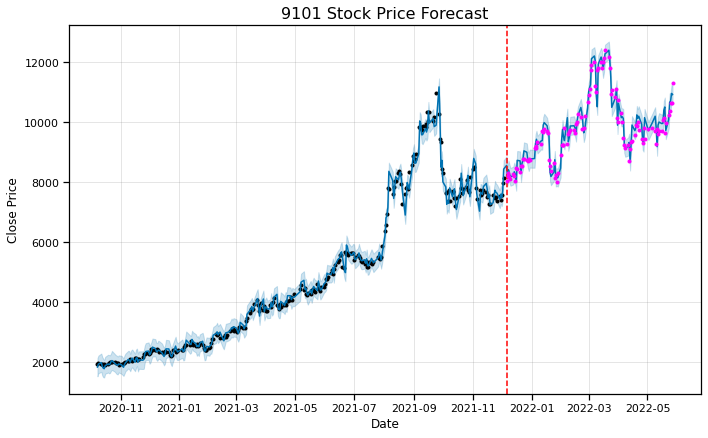

In [21]:
fig = m.plot(forecast)
plt.title(f"{Code} Stock Price Forecast", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.axvline(TEST.index[0], color='red', linestyle='--')
plt.plot(TEST.index, TEST.Close,  marker="o", markersize=3, color="magenta", linewidth=0, label="Test Close")
plt.show()

This code is used to plot a stock price forecast using some stock price data.   First, the code creates a figure object named "fig" and plots the stock price forecast on it. The forecast data is provided as the "forecast" variable.   Next, the code sets a title for the plot using the string formatting method. The title is set to "{Code} Stock Price Forecast", where "{Code}" is likely a placeholder for a specific stock code. The title font size is set to 16.  Then, the code sets the x-axis label to "Date" and the y-axis label to "Close Price". The font size for both labels is specified as 12.  The code adds a vertical line on the plot at the index of the first date in the "TEST" variable. The line color is set to red and the line style is set to dashed.  The code also plots the actual test data on the plot. The x-axis values are taken from the index of the "TEST" variable, representing dates, and the y-axis values are taken from the "Close" column of the "TEST" variable, representing the closing prices. The plot uses circles as markers for each data point, with a size of 3. The line color is set to magenta. The line width is set to 0, meaning no lines are drawn between the data points. A label "Test Close" is provided for the legend.  Finally, the code displays the plot.

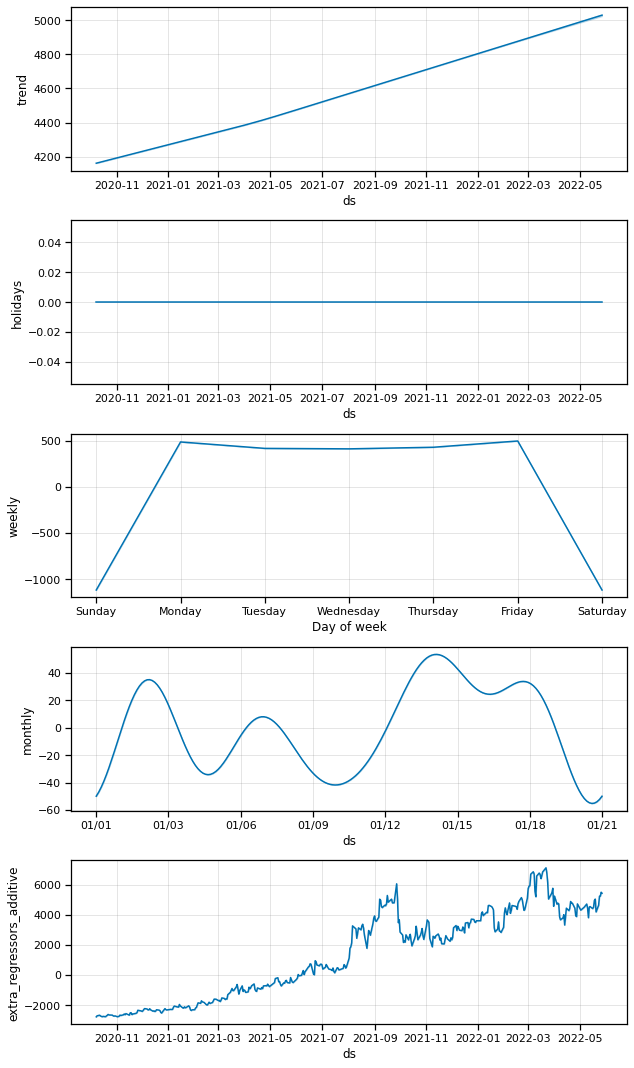

In [22]:
fig2 = m.plot_components(forecast)
plt.show()

This code is used to plot the forecast components of the time series data using the "Prophet" library in Python. The "forecast" object represents the predicted values of the time series and the "m" object represents the Prophet model that was used to generate the forecast.   The "plot_components" function is a built-in function provided by the Prophet library, which is used to visualize the individual components of the forecast. These components include the trend, seasonality, and any additional regressor variables that were used in the model.   By calling the "plot_components" function with the "forecast" object as an argument, it generates plots for each component, showing the patterns and variations present in the time series data. These plots provide insights into how each component contributes to the overall forecast and help in understanding the underlying patterns within the data.   Finally, the "plt.show()" function is used to display the plots on the screen. It is a built-in function provided by the Matplotlib library, which is a popular data visualization library in Python. The plots will be displayed in a separate window or within the Jupyter Notebook, depending on the environment in which the code is being executed.

Rolling Traning and Predict

In [23]:
# Utilities 

def calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    weights_mean = weights.mean()
    df = df.sort_values(by='Rank')
    purchase = (df['Target'][:portfolio_size]  * weights).sum() / weights_mean
    short    = (df['Target'][-portfolio_size:] * weights[::-1]).sum() / weights_mean
    return purchase - short

def calc_spread_return_sharpe(df, portfolio_size=200, toprank_weight_ratio=2):
    grp = df.groupby('Date')
    min_size = grp["Target"].count().min()
    if min_size<2*portfolio_size:
        portfolio_size=min_size//2
        if portfolio_size<1:
            return 0, None
    buf = grp.apply(calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio, buf

def add_rank(df, col_name="pred"):
    df["Rank"] = df.groupby("Date")[col_name].rank(ascending=False, method="first") - 1 
    df["Rank"] = df["Rank"].astype("int")
    return df

This code is a set of utility functions for calculating spread returns and rankings of a DataFrame.   The `calc_spread_return_per_day` function takes a DataFrame (`df`), the size of the portfolio (`portfolio_size`), and a weight ratio for the top-ranked items (`toprank_weight_ratio`). It calculates the spread return for each day by sorting the DataFrame by the 'Rank' column, calculating the weighted sum of the 'Target' column for the top-ranked items and the bottom-ranked items, and then subtracting the two sums.  The `calc_spread_return_sharpe` function takes a DataFrame (`df`), with optional parameters for portfolio size (`portfolio_size`) and top-ranked weight ratio (`toprank_weight_ratio`). It groups the DataFrame by date (`Date`) and checks the minimum size of the 'Target' column for each date. If the minimum size is less than twice the portfolio size, it adjusts the portfolio size to be half of the minimum size. If the adjusted portfolio size is less than 1, the function returns 0 and None. Otherwise, it applies the `calc_spread_return_per_day` function to each date group to calculate the spread return for each day. The function then calculates the mean and standard deviation of the spread returns and calculates the Sharpe ratio by dividing the mean by the standard deviation. It returns the Sharpe ratio and the spread returns in a DataFrame.  The `add_rank` function takes a DataFrame (`df`) and an optional column name (`col_name`, default is "pred"). It adds a new column to the DataFrame called 'Rank' by grouping the DataFrame by date (`Date`), ranking the values in the specified column (`col_name`) in descending order, and subtracting 1 to start the ranking at 0. It converts the 'Rank' column to integer type and returns the modified DataFrame.

In [24]:
def add_feat(df):
    df['C3'] = df.Close.rolling(window=3,closed="left").apply(lambda y: 
               np.poly1d(np.polyfit([0,1,2],y,1))(3),raw=True)        
    df['C2'] = df.Close.rolling(window=2,closed="left").apply(lambda y: 
               np.poly1d(np.polyfit([0,1],y,1))(2),raw=True)
    return df

def run_prophet(tr):
    m = Prophet(holidays=holidays,
                daily_seasonality=False,
                yearly_seasonality=False,
                weekly_seasonality=False,
                changepoint_prior_scale=0.01)
    m.add_regressor('C3')
    m.add_regressor('C2')
    m.fit(tr)
    pred = m.predict(tr[-2:])
    return (pred.yhat[1]/pred.yhat[0] - 1)

def run_reg(tr):
    pred = list(0.6*tr.C2[-2:]+0.4*tr.C3[-2:])
    return (pred[1]/pred[0] - 1)

def proc_cod(cod, tr):
    tr = tr[tr.SecuritiesCode==cod][["Date","Close"]]
    x = [0,1]
    for _ in x:
        tr = tr.append(
        pd.DataFrame({'Date': pd.date_range(start=tr.Date.iloc[-1], 
                                            periods=2, freq='B', 
                                            closed='right'),
                      'Close': np.poly1d(np.polyfit(x,tr.Close[-2:],1))(2)
                     })
        )
    tr = add_feat(tr)
    tr = tr[6:]
    target = run_reg(tr)
    return target

This code defines several functions and a main processing function.   The `add_feat` function takes a DataFrame `df` as input and adds two new columns to it. The first column 'C3' is calculated by applying a rolling window function to the 'Close' column with a window size of 3. It uses the `polyfit` function from `numpy` to fit a 1-degree polynomial to the last 3 values of 'Close' and then evaluates it at the value 3. The second column 'C2' is calculated in a similar way, but with a window size of 2.  The `run_prophet` function takes a DataFrame `tr` as input and fits a Prophet model to it. It configures the model to disable daily, yearly, and weekly seasonality, and sets the changepoint prior scale to 0.01. It then adds the 'C3' and 'C2' columns as regressor variables to the model, fits it to the data, and uses the model to make predictions for the last 2 data points in `tr`. The function returns the difference between the predicted values at the second and first data points, divided by the predicted value at the first data point minus 1.  The `run_reg` function takes a DataFrame `tr` as input and calculates a prediction using the 'C2' and 'C3' columns. It multiplies the 'C2' column values by 0.6 and the 'C3' column values by 0.4, and sums them. It returns the difference between the second and first values in the prediction list, divided by the first value minus 1.  The `proc_cod` function takes a 'cod' value and a DataFrame `tr` as input. It filters `tr` based on the 'SecuritiesCode' column matching the 'cod' value and selects the 'Date' and 'Close' columns. It then iterates over a list of [0, 1] and for each value, appends a DataFrame with the last two dates and the predicted values based on a 1-degree polynomial fit of the last two 'Close' values. The `add_feat` function is called to add the 'C3' and 'C2' columns to the DataFrame. The function then removes the first 6 rows from the DataFrame and calls the `run_reg` function to calculate the target value. The function returns the target value.

In [25]:
%%time
import jpx_tokyo_market_prediction

env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

trgts = {}
for (prices, _, _, _, _, sample_prediction) in iter_test:
    cods = prices.SecuritiesCode.unique()
    df_train = pd.concat([df_train, prices])
    df_train = df_train.sort_values(["SecuritiesCode", "Date"])
    df_train.ffill(inplace=True)
    for cod in tqdm(cods):
        trgts[cod] = proc_cod(cod, df_train)
    tr = df_train[df_train.Date==prices.Date.iat[0]].copy()
    tr.Target=tr["SecuritiesCode"].map(trgts) 
    tr = add_rank(tr, "Target")
    score = calc_spread_return_per_day(tr,200,2)
    print(f"Score: {score}")
    pred = tr.set_index("SecuritiesCode")["Rank"]
    sample_prediction['Rank'] = sample_prediction["SecuritiesCode"].map(pred)
    env.predict(sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


  0%|          | 0/2000 [00:00<?, ?it/s]

Score: 20.49374305578772


  0%|          | 0/2000 [00:00<?, ?it/s]

Score: 18.22635115926563
CPU times: user 4min 37s, sys: 1.45 s, total: 4min 39s
Wall time: 4min 37s


This code is performing some tasks related to market prediction in the Tokyo Stock Exchange (JPX).   First, the code imports a module called "jpx_tokyo_market_prediction" that likely contains functions and classes for making market predictions in the Tokyo Stock Exchange.  Next, it creates an environment using the make_env() function from the jpx_tokyo_market_prediction module.  Then, it initializes an iterator for testing data using the iter_test() function from the environment.  The code defines an empty dictionary called trgts to store target values for each security code.  The loop
iterates through the test data provided by the iterator, for each iteration, it extracts the unique securities codes from the prices data.  Then, it concatenates the prices data with a dataframe called df_train, which likely contains historical training data.  The dataframe df_train is sorted by "SecuritiesCode" and "Date".  Missing values in df_train are filled using the forward fill method (ffill() function).  Next, for each securities code, it calls a function called proc_cod() from the
jpx_tokyo_market_prediction module, passing the securities code and df_train as arguments. The result of proc_cod() is stored in trgts dictionary, with the securities code as the key.  After that, a subset of df_train is created with rows that have the same date as the prices data. This subset is assigned to the variable tr.  The "Target" column of tr is mapped with the trgts values using the "SecuritiesCode" column as the key. This assigns the target values to the appropriate rows in tr.  A function called add_rank() is called, passing tr and "Target" as arguments. This function likely adds a "Rank" column to tr based on some ranking criteria.  The spread return per day is calculated using the calc_spread_return_per_day() function, passing tr, 200, and 2 as arguments. The result is stored in the variable score.  The score is printed.  A new dataframe is created by setting the index of tr to "SecuritiesCode", and only keeping the "Rank" column. This new dataframe is assigned to the variable pred.  The "Rank" column of the sample_prediction dataframe is mapped with the pred values using the "SecuritiesCode" column as the key.  Finally, the predictions are made in the environment using the env.predict() function, passing the sample_prediction dataframe as an argument.